# Proyecto Final: Lectura de planos CAD

Pruebas realizadas sobre [floor plan](https://drive.google.com/file/d/1Xw-cIvnZdvCMmrIfRs5FkywCXhw-ASOz/view?usp=sharing) el cual puede ser observado con AutoCAD o [ShareCAD](https://sharecad.org/) o [Autodesk Viewer](https://viewer.autodesk.com/)

In [1]:
!python -m pip install ezdxf geopandas

     |████████████████████████████████| 2.4 MB 14.4 MB/s 
     |████████████████████████████████| 1.0 MB 47.3 MB/s 
     |████████████████████████████████| 6.3 MB 41.1 MB/s 
     |████████████████████████████████| 16.7 MB 46.3 MB/s 


In [2]:
import ezdxf
import geopandas as gpd
import pandas as pd
import fiona; help(fiona.open)
import numpy as np
from shapely.geometry import Polygon, box
import shapely.ops as so
import matplotlib.pyplot as plt
from typing import *

Help on function open in module fiona:

open(fp, mode='r', driver=None, schema=None, crs=None, encoding=None, layer=None, vfs=None, enabled_drivers=None, crs_wkt=None, **kwargs)
    Open a collection for read, append, or write
    
    In write mode, a driver name such as "ESRI Shapefile" or "GPX" (see
    OGR docs or ``ogr2ogr --help`` on the command line) and a schema
    mapping such as:
    
      {'geometry': 'Point',
       'properties': [('class', 'int'), ('label', 'str'),
                      ('value', 'float')]}
    
    must be provided. If a particular ordering of properties ("fields"
    in GIS parlance) in the written file is desired, a list of (key,
    value) pairs as above or an ordered dict is required. If no ordering
    is needed, a standard dict will suffice.
    
    A coordinate reference system for collections in write mode can be
    defined by the ``crs`` parameter. It takes Proj4 style mappings like
    
      {'proj': 'longlat', 'ellps': 'WGS84', 'datum': 'W

## Definicion de clases custom

In [45]:
class Square(Polygon):
  def __init__(self, side:float, start_x: float=0, start_y: float=0):
    end_x = start_x+side
    end_y = start_y+side
    return super().__init__([(start_x, start_y), (end_x, start_y), (end_x, end_y), (start_x, end_y)])


class OccupancyGrid:
    def __init__(self, cell_size: float, x_cells: int, y_cells: int) -> None:
        self._cell_size = cell_size
        self._x_cells = x_cells
        self._y_cells = y_cells
        self._grid = np.zeros(
            (x_cells, y_cells), dtype=np.int8
        )  # grid containing ints between 0 and 100, representing % occupancy

    def get_cell_size(self) -> float:
        return self._cell_size

    def get_x_cells(self) -> int:
        return self._x_cells

    def get_y_cells(self) -> int:
        return self._y_cells

    def get_grid(self) -> np.ndarray:
        return self._grid

    # gets the occupancy percentage given X and Y coordinates
    def __getitem__(self, index: Tuple[int, int]) -> int:
        return self._grid[index]

    # sets the occupancy percentage given X and Y coordinates
    def __setitem__(self, index: Tuple[int, int], value: int) -> None:
        assert value >= 0 and value <= 100
        self._grid[index] = value

    def plot(self, figsize=(10,10)) -> plt.figure:
        # Create a new figure
        fig = plt.figure(figsize=figsize)

        ax = fig.gca()

        # Plot the grid
        ax.pcolormesh(self.get_grid().T, cmap="PuBu", edgecolor="k", lw=2)
        # return fig
    def get_occupied_cells(self) -> np.ndarray:
        return np.transpose(np.nonzero(self._grid))
    
    def get_empty_cells(self) -> np.ndarray:
        return np.transpose(np.nonzero(self._grid == 0))

## Lectura del plano en formato .dxf

In [4]:
doc = ezdxf.readfile("/content/drive/MyDrive/Proyecto final/Floor plan.dxf")
clean_doc = ezdxf.new('R2010')
msp = doc.modelspace()
clean_msp = clean_doc.modelspace()

for e in msp.query("LINE [layer=='xref-Bishop-Overland-08$0$A-WALL']"):
    clean_msp.add_line(start=e.dxf.start, end=e.dxf.end)

clean_doc.saveas("/content/drive/MyDrive/Proyecto final/Floor plan clean.dxf")

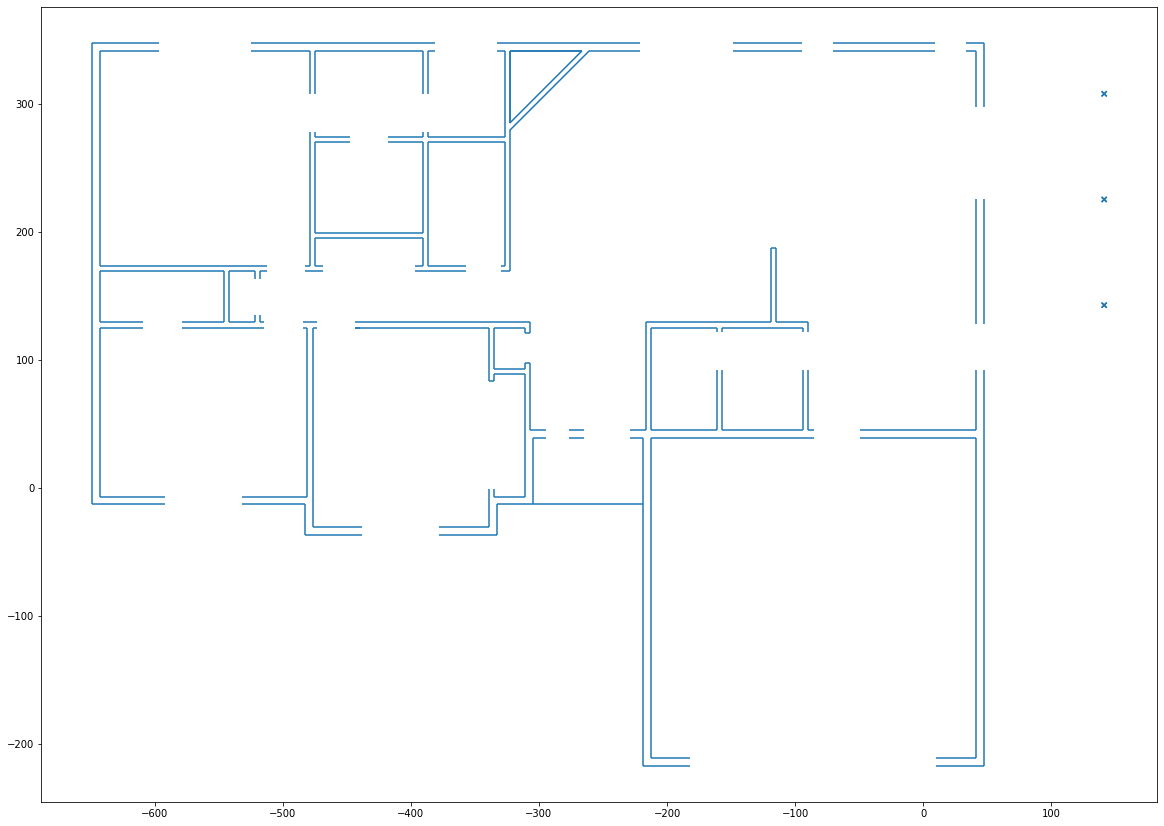

In [5]:
layout = gpd.read_file("/content/drive/MyDrive/Proyecto final/Floor plan clean.dxf")
layout.plot(figsize=(20,20))

## Conversion de plano a grilla de ocupacion
Una vez levantado el plano de CAD, procedemos a crear una grilla de ocupacion, definida por cuadrados de lado `square_size`, los cuales se buscaran superponer al plano obtenido.
Asi, los poligonos que coincidan con las lineas del plano seran aquellos que formaran parte de los **bloques ocupados** en la grilla de ocupacion.

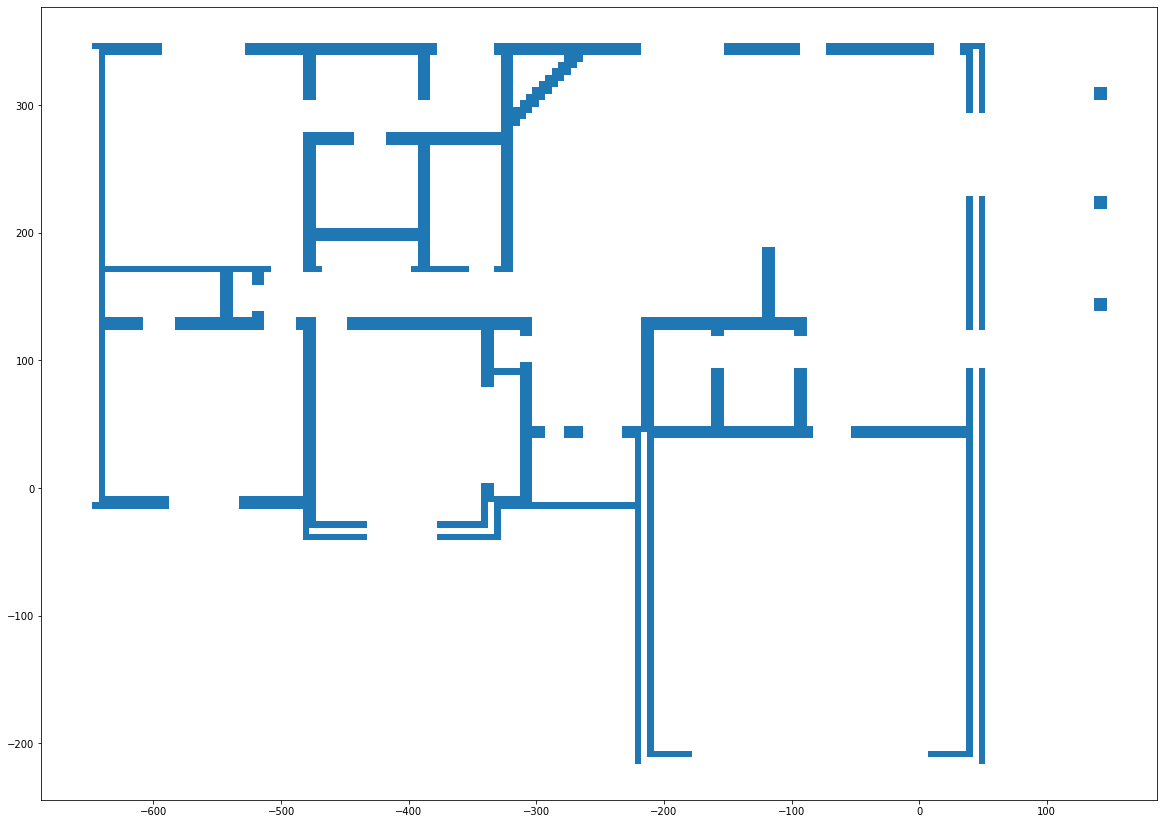

In [44]:
clean_layout = layout['geometry']
xmin, ymin, xmax, ymax = clean_layout.total_bounds

polygons_list = []
square_size = 5
for xstart in range(int(xmin), int(xmax), square_size):
  for ystart in range(int(ymin), int(ymax), square_size):
    polygons_list.append(Square(square_size, xstart, ystart))


shape = gpd.GeoDataFrame(geometry=polygons_list)
shape["intersects"]= shape.intersects(clean_layout.unary_union)
occupied_blocks = shape.query("intersects == True")
occupied_blocks.plot(figsize=(20,20))

In [46]:
def get_center(item):
  xmin, ymin, xmax, ymax = item["geometry"].bounds
  return pd.Series([(xmax+xmin)/2, (ymax+ymin)/2, int(item["intersects"])], index=['axis_x', 'axis_y', 'occuped'])
occupancy_grid = shape.apply(get_center, axis=1, result_type='expand').pivot(index ='axis_x', columns ='axis_y', values='occuped')
occupancy_grid

axis_y,-213.5,-208.5,-203.5,-198.5,-193.5,-188.5,-183.5,-178.5,-173.5,-168.5,...,301.5,306.5,311.5,316.5,321.5,326.5,331.5,336.5,341.5,346.5
axis_x,,,,,,,,,,,,,,,,,,,,,
-645.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
-640.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
-635.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
-630.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
-625.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
129.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
134.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


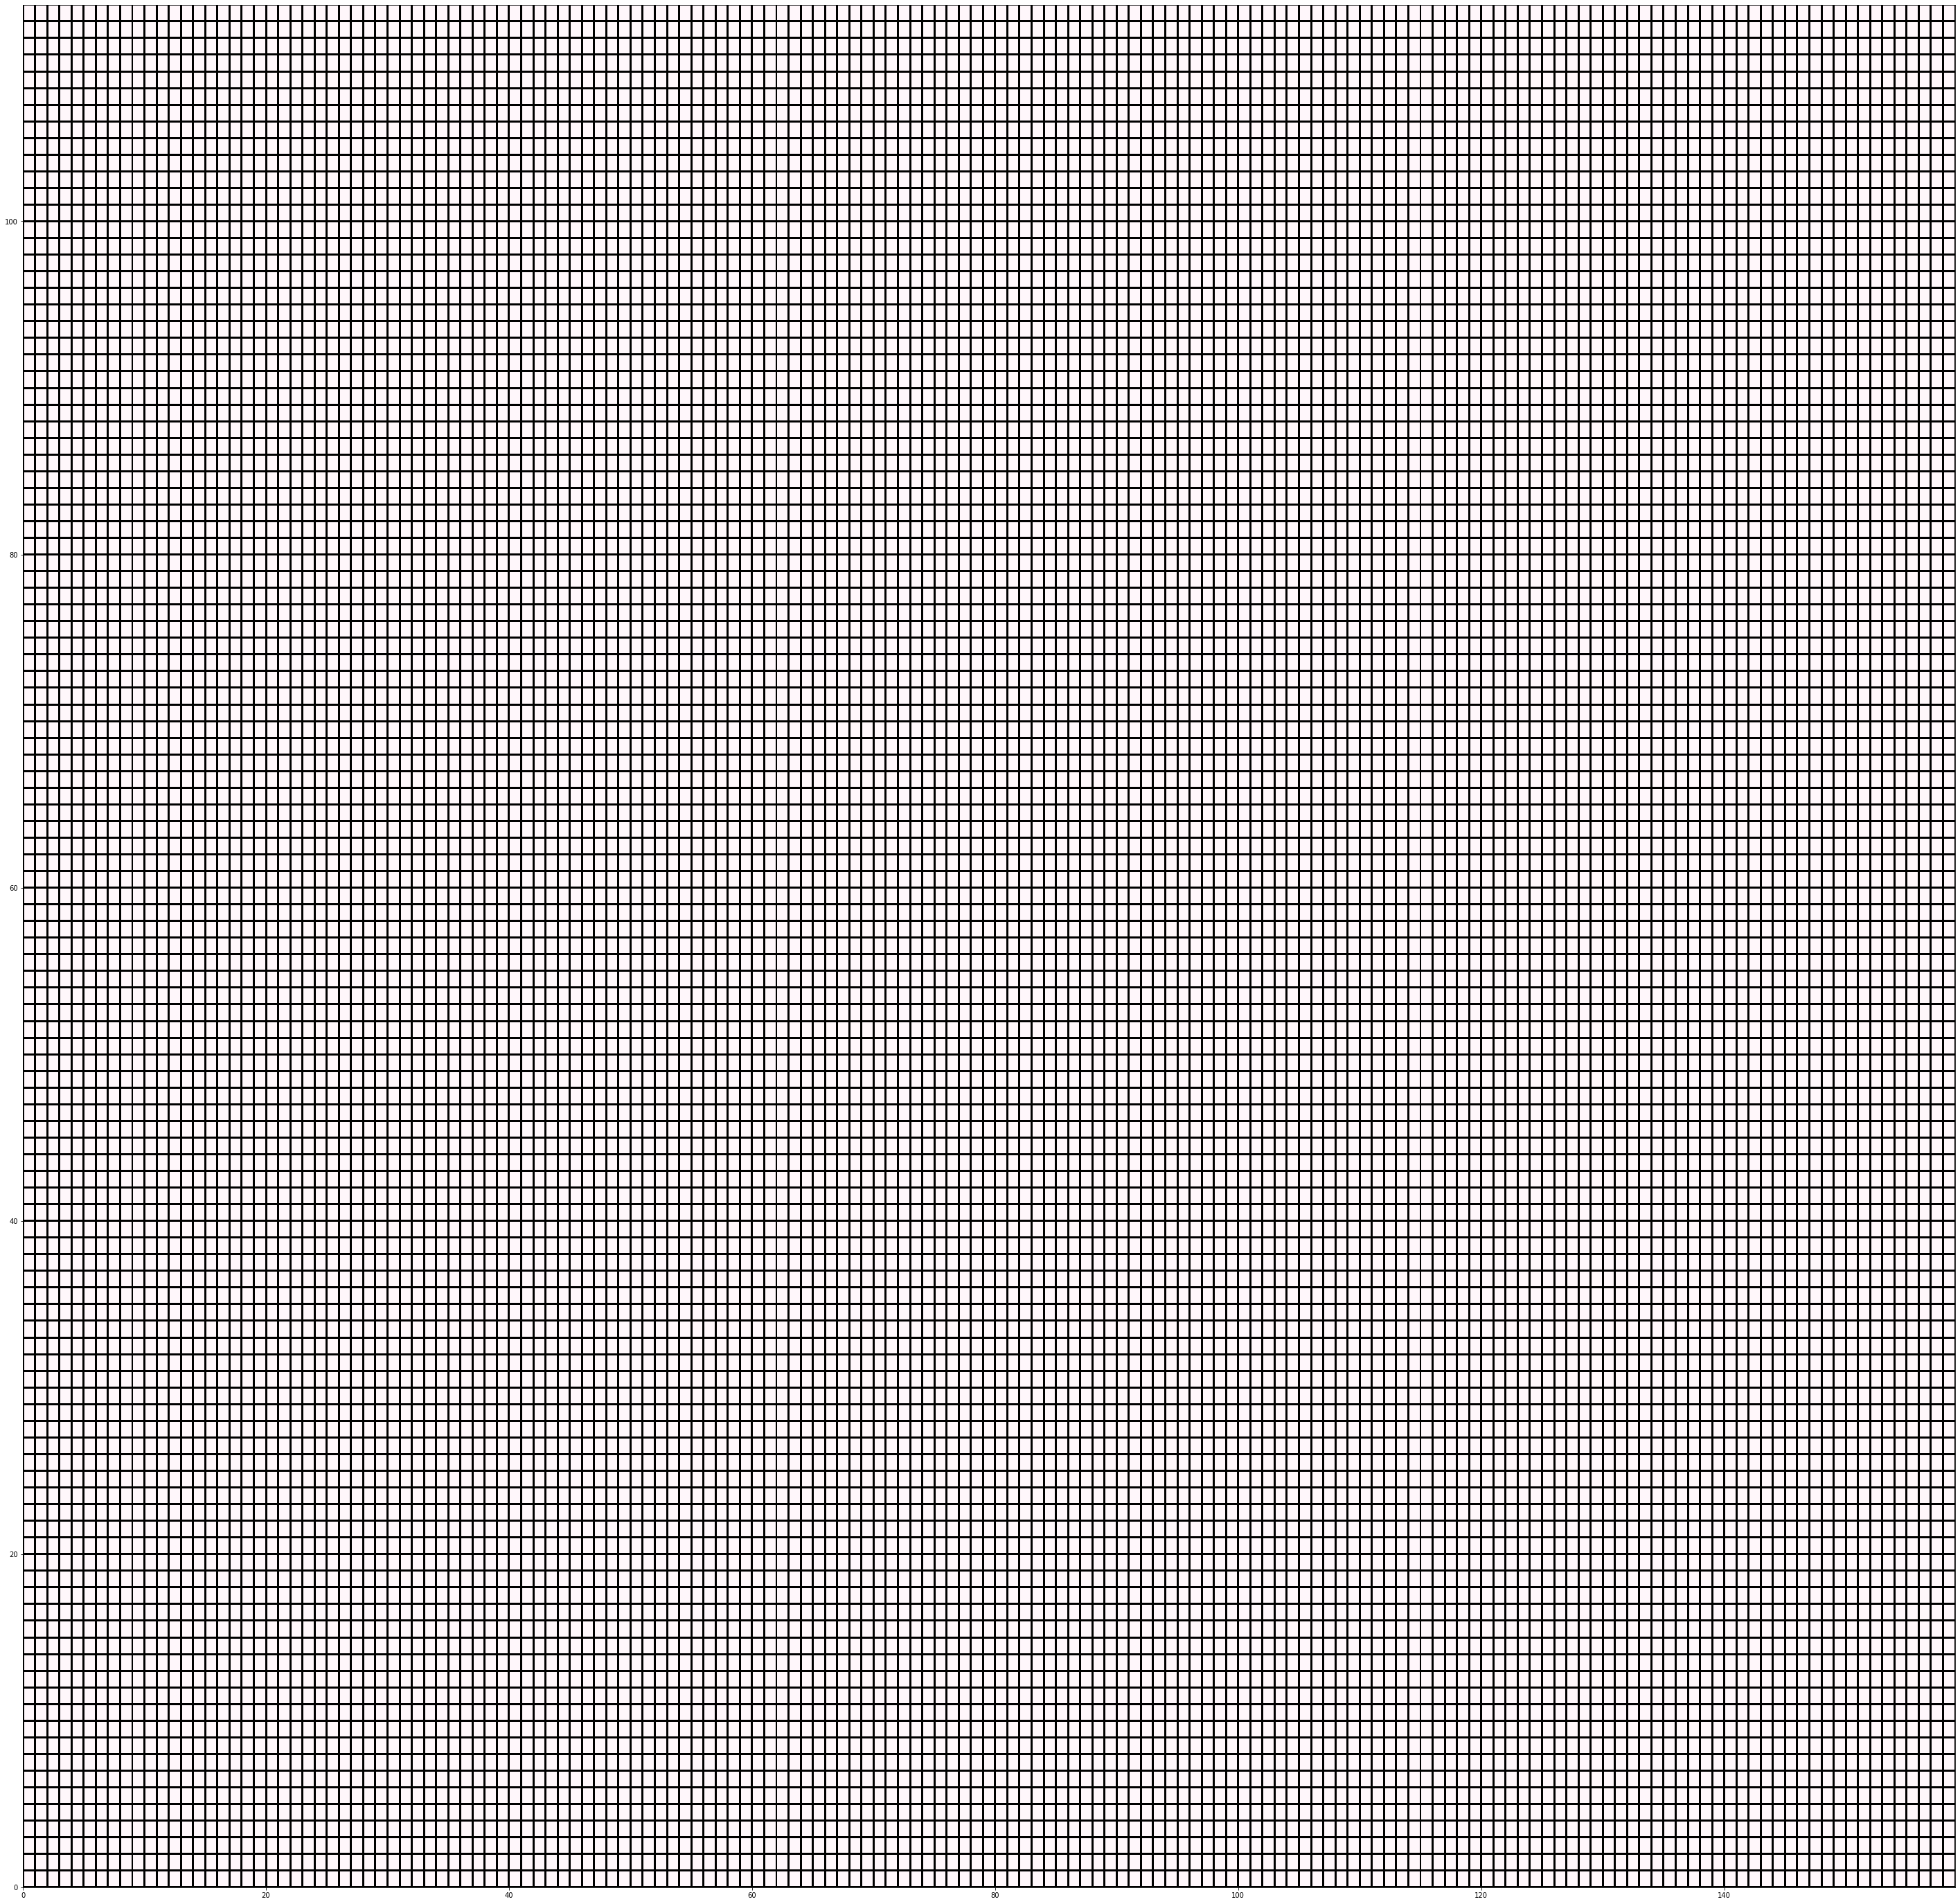

In [47]:
grid = OccupancyGrid(square_size, occupancy_grid.shape[0], occupancy_grid.shape[1])
grid.plot(figsize=(50, 50))

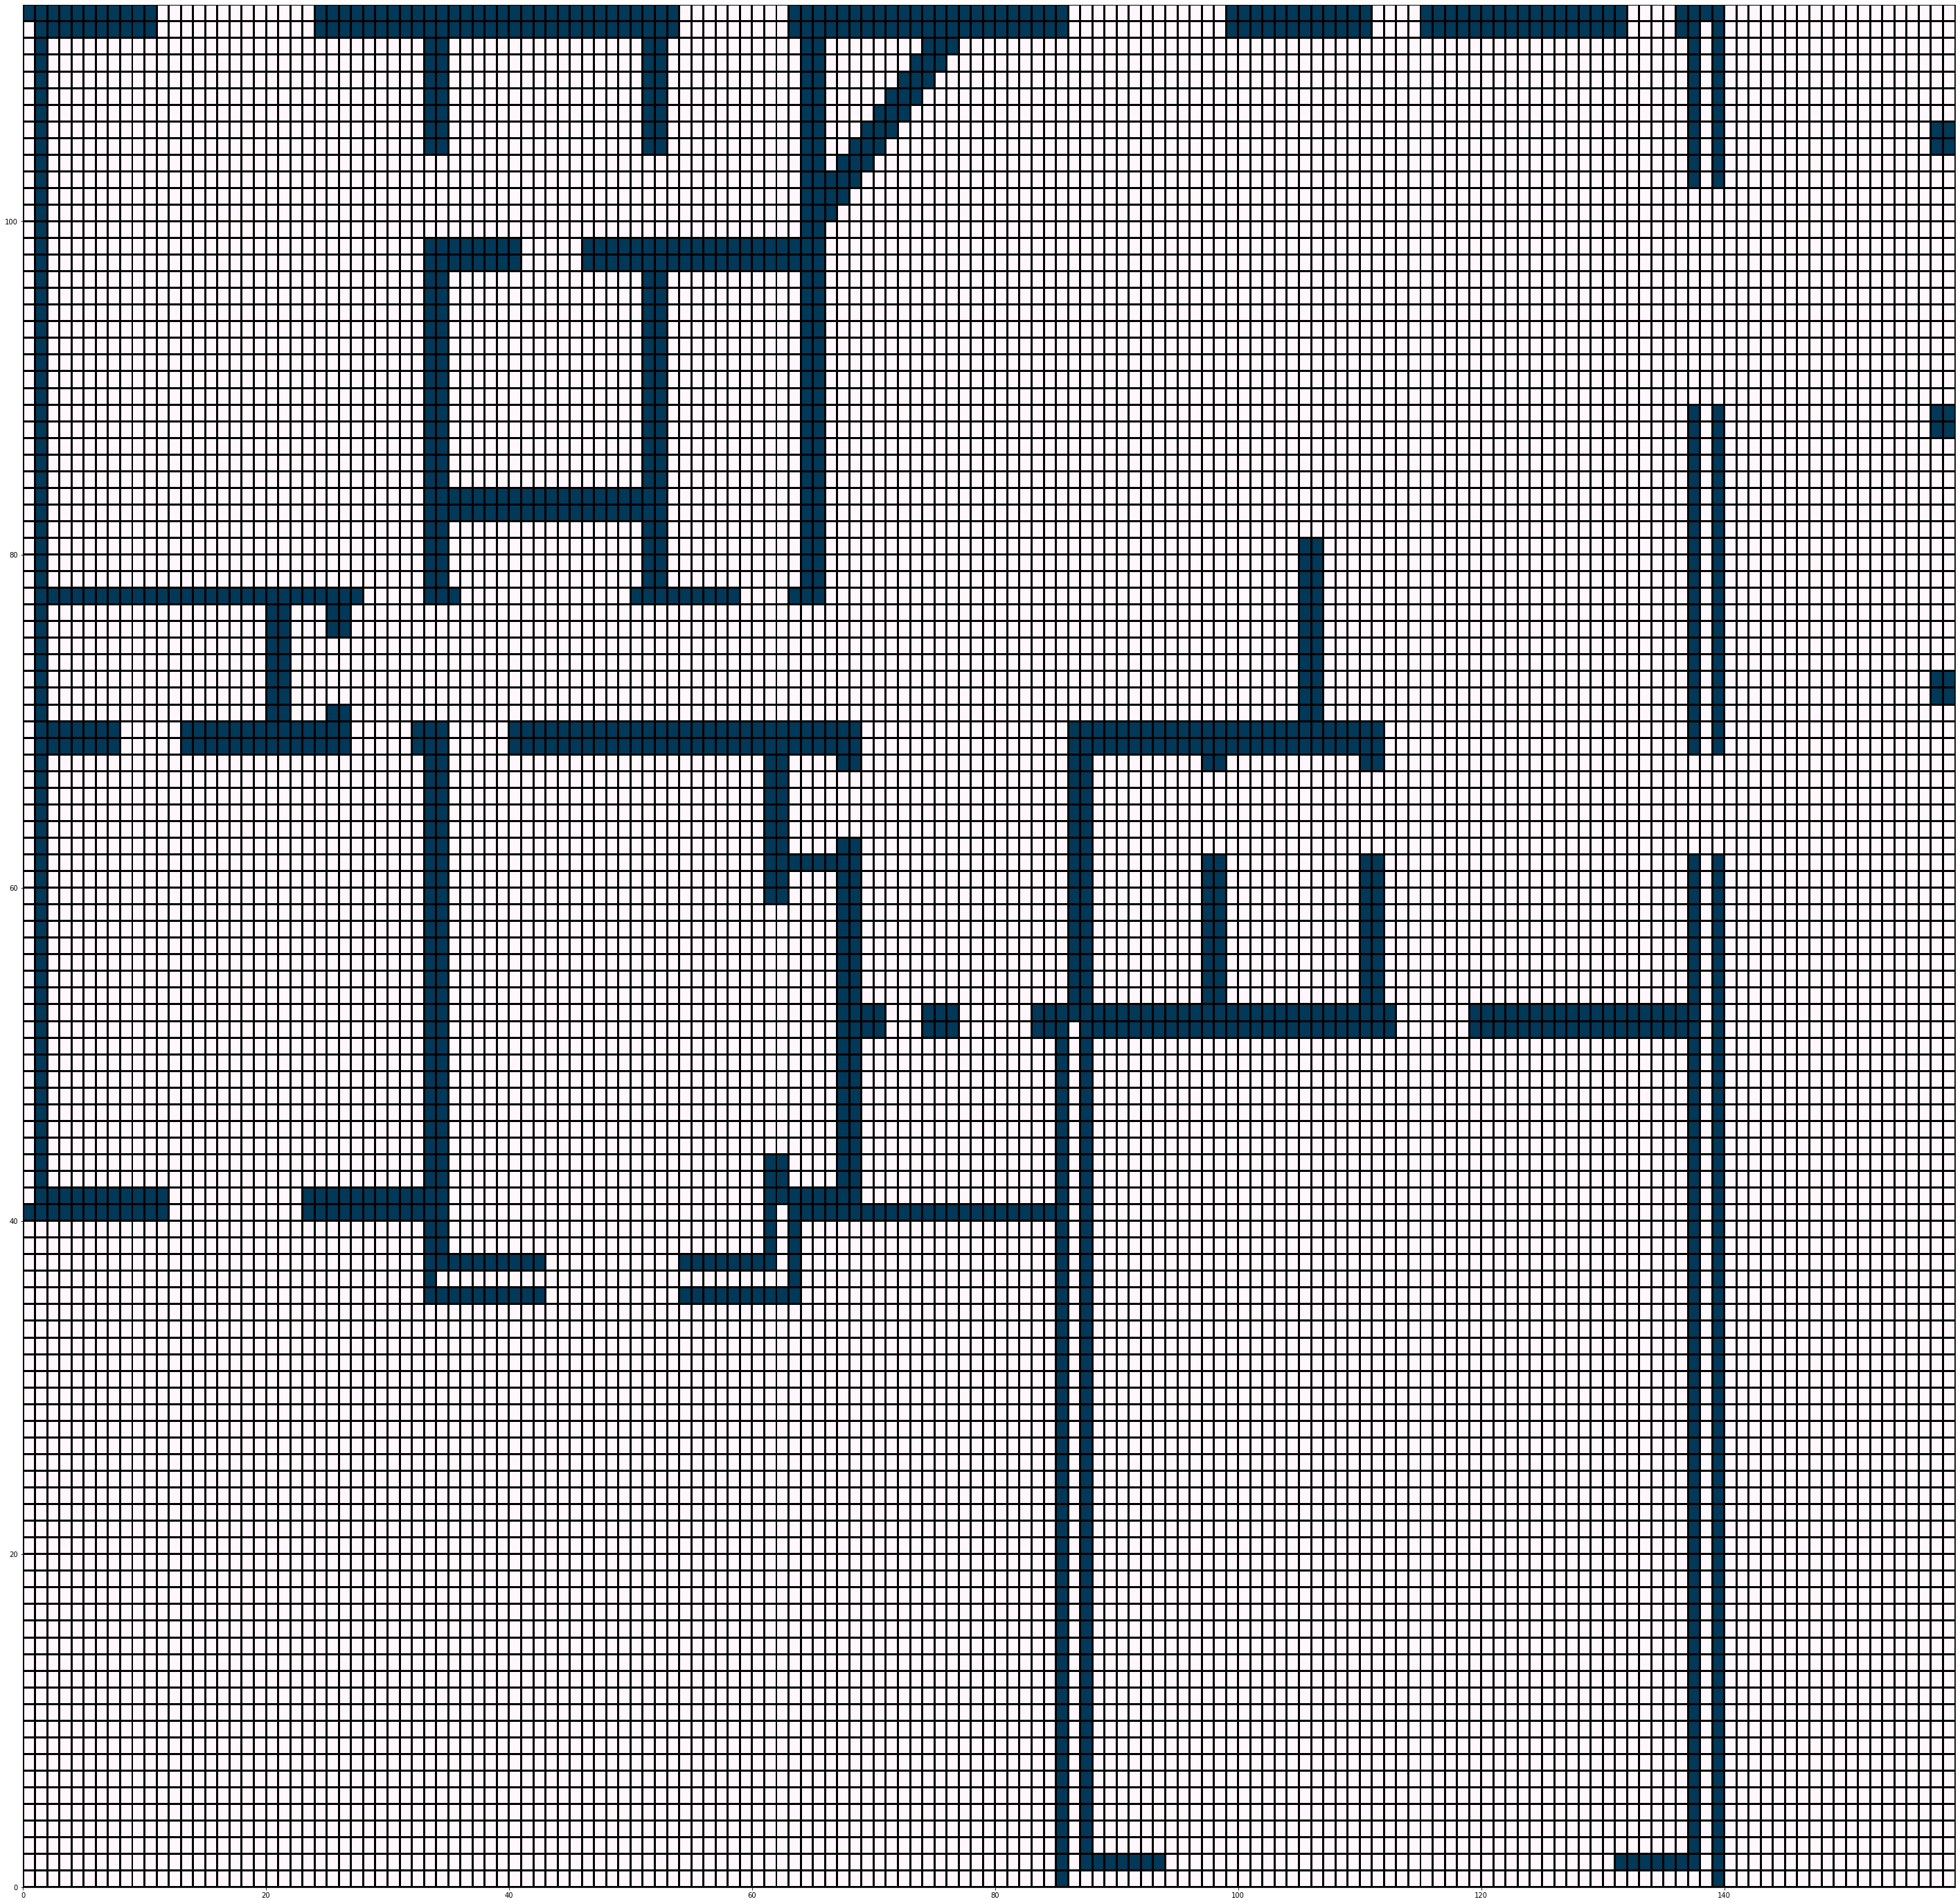

In [49]:
for x in range(grid.get_x_cells()):
  for y in range(grid.get_y_cells()):
    grid[x, y] = 100 if occupancy_grid.iloc[x, y] else 0
grid.plot(figsize=(50, 50))